In [42]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
import torchvision.models as models
from matplotlib import pyplot as plt
import timm
import optuna
from sklearn.metrics import accuracy_score, f1_score

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
Memory: 12.9 GB


## Load Data

In [44]:
image_transforms = transforms.Compose([
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(10),
	transforms.ColorJitter(contrast=0.2, brightness=0.2),
	transforms.Resize((224, 224)),  # Match ResNet50 pretrained input size
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [45]:
data_path = './dataset'

dataset = datasets.ImageFolder(root=data_path, transform=image_transforms)
len(dataset)

2310

In [46]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [47]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_size, test_size

(1732, 578)

In [48]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [49]:
for image, label in train_loader:
	print(image.shape)
	print(label.shape)
	break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [50]:
label[50], image[1].shape

(tensor(3), torch.Size([3, 224, 224]))

In [51]:
image[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].


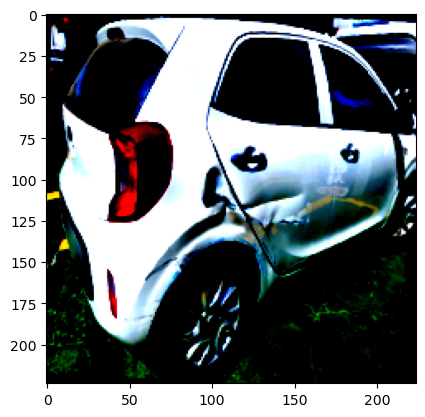

In [52]:
plt.imshow(image[50].permute(1,2,0))
plt.show()

In [53]:
image.size(0), len(train_loader.dataset)

(64, 1732)

In [54]:
for images, labels in train_loader:
    print(f"Image shape: {images.shape}")
    break

Image shape: torch.Size([64, 3, 224, 224])


In [55]:
# Training function for Optuna
def train_model_optuna(model, criterion, optimizer, epochs, device, train_loader, val_loader, trial=None):
    model.to(device)
    best_val_acc = 0.0
    
    # Learning rate scheduler for better convergence
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Step the scheduler after each epoch
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        epoch_loss = running_loss / len(train_loader.dataset)
        val_epoch_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch [{epoch + 1}/{epochs}]')
        print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Update best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Report intermediate results to Optuna for pruning
        if trial:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
    return best_val_acc

In [56]:
model = models.efficientnet_v2_m(pretrained=True)
model.classifier[1].in_features

c:\Users\poohz\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\poohz\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1280

### Model 2: Transfer Learning with ResNet50

In [57]:
# Updated model class
class CarDamageClassResNet50(nn.Module):
    def __init__(self, num_class, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_class)
        )
    
    def forward(self, x):
        return self.model(x)

### Hyperparameter Tuning

In [58]:
# Objective function for Optuna optimization
def objective(trial):
    # Hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.7),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True),
        'optimizer_name': trial.suggest_categorical('optimizer_name', ['Adam', 'SGD', 'AdamW']),
        'epochs': trial.suggest_int('epochs', 10, 30),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    }
    
    # SGD-specific parameters
    if params['optimizer_name'] == 'SGD':
        params['momentum'] = trial.suggest_float('momentum', 0.8, 0.99)
        params['nesterov'] = trial.suggest_categorical('nesterov', [True, False])
    
    print(f"Trial {trial.number}: Testing parameters {params}")
    
    try:
        # Rebuild data loaders with trial batch size
        trial_train_loader = DataLoader(train_sub_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
        trial_val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
        
        # Create model
        model = CarDamageClassResNet50(
            num_class=num_classes,
            dropout_rate=params['dropout_rate']
        )
        
        # Create optimizer
        if params['optimizer_name'] == 'Adam':
            optimizer = optim.Adam(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
        elif params['optimizer_name'] == 'SGD':
            optimizer = optim.SGD(
                model.parameters(),
                lr=params['learning_rate'],
                momentum=params['momentum'],
                weight_decay=params['weight_decay'],
                nesterov=params['nesterov']
            )
        elif params['optimizer_name'] == 'AdamW':
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Train the model with trial-suggested epochs
        best_val_acc = train_model_optuna(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            epochs=params['epochs'],
            device=device,
            train_loader=trial_train_loader,
            val_loader=trial_val_loader,
            trial=trial
        )
        
        return best_val_acc
        
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        return 0.0

In [59]:
# Main hyperparameter tuning function
def run_hyperparameter_tuning(n_trials=50):
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=1
        )
    )
    
    # Run optimization
    study.optimize(objective, n_trials=n_trials)
    
    # Print results
    print("Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nBest validation accuracy: {study.best_value:.4f}")
    
    # Get top 5 trials
    print("\nTop 5 trials:")
    for i, trial in enumerate(study.trials_dataframe().nlargest(5, 'value').iterrows()):
        print(f"  Trial {i+1}: {trial[1]['value']:.4f}")
    
    return study

In [60]:
# Function to get best parameters
def get_best_parameters(study):
    """
    Extract and return the best parameters found by Optuna
    """
    best_params = study.best_params
    print("Best parameters found:")
    print("="*50)
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print("="*50)
    print(f"Best validation accuracy: {study.best_value:.4f}")
    
    return best_params

In [61]:
num_classes = len(dataset.classes)

# Split validation from TRAINING data (not test) to avoid data leakage
val_size = int(0.15 * len(train_dataset))
train_size_new = len(train_dataset) - val_size
train_sub_dataset, val_dataset = random_split(train_dataset, [train_size_new, val_size])

# Rebuild train_loader with the reduced training set
train_loader = DataLoader(train_sub_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train: {len(train_sub_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Run hyperparameter tuning
study = run_hyperparameter_tuning(n_trials=20)

# Get best parameters
best_params = get_best_parameters(study)
best_params

[I 2026-02-17 06:35:48,180] A new study created in memory with name: no-name-3d84e304-cc59-4a16-bee9-62a64fa5ba12


Train: 1473, Val: 259, Test: 578
Trial 0: Testing parameters {'learning_rate': 0.0001238539926153332, 'dropout_rate': 0.4197948167612606, 'weight_decay': 0.000973886944374594, 'optimizer_name': 'SGD', 'epochs': 17, 'batch_size': 16, 'momentum': 0.9660963820943167, 'nesterov': True}
Epoch [1/17]
  Train Loss: 1.7519, Train Acc: 0.2682
  Val Loss: 1.6877, Val Acc: 0.3629
Epoch [2/17]
  Train Loss: 1.6374, Train Acc: 0.3680
  Val Loss: 1.5687, Val Acc: 0.4170
Epoch [3/17]
  Train Loss: 1.5115, Train Acc: 0.4162
  Val Loss: 1.4846, Val Acc: 0.4633
Epoch [4/17]
  Train Loss: 1.3551, Train Acc: 0.4888
  Val Loss: 1.3262, Val Acc: 0.5560
Epoch [5/17]
  Train Loss: 1.2285, Train Acc: 0.5526
  Val Loss: 1.2158, Val Acc: 0.6178
Epoch [6/17]
  Train Loss: 1.1127, Train Acc: 0.5981
  Val Loss: 1.0777, Val Acc: 0.6409
Epoch [7/17]
  Train Loss: 1.0290, Train Acc: 0.6205
  Val Loss: 1.0303, Val Acc: 0.6486
Epoch [8/17]
  Train Loss: 0.9532, Train Acc: 0.6456
  Val Loss: 0.9696, Val Acc: 0.7027
Epoch

[I 2026-02-17 06:44:27,160] Trial 0 finished with value: 0.7258687258687259 and parameters: {'learning_rate': 0.0001238539926153332, 'dropout_rate': 0.4197948167612606, 'weight_decay': 0.000973886944374594, 'optimizer_name': 'SGD', 'epochs': 17, 'batch_size': 16, 'momentum': 0.9660963820943167, 'nesterov': True}. Best is trial 0 with value: 0.7258687258687259.


Epoch [17/17]
  Train Loss: 0.7882, Train Acc: 0.6850
  Val Loss: 0.8285, Val Acc: 0.7259
Trial 1: Testing parameters {'learning_rate': 0.0016017314965174885, 'dropout_rate': 0.4993308029162373, 'weight_decay': 0.000913086892417927, 'optimizer_name': 'AdamW', 'epochs': 22, 'batch_size': 128}
Epoch [1/22]
  Train Loss: 1.0281, Train Acc: 0.5574
  Val Loss: 1.3234, Val Acc: 0.6216
Epoch [2/22]
  Train Loss: 0.4739, Train Acc: 0.8153
  Val Loss: 0.5473, Val Acc: 0.8147
Epoch [3/22]
  Train Loss: 0.3006, Train Acc: 0.8832
  Val Loss: 0.7260, Val Acc: 0.8031
Epoch [4/22]
  Train Loss: 0.1885, Train Acc: 0.9369
  Val Loss: 0.7641, Val Acc: 0.7761
Epoch [5/22]
  Train Loss: 0.1244, Train Acc: 0.9572
  Val Loss: 0.9127, Val Acc: 0.7992
Epoch [6/22]
  Train Loss: 0.1118, Train Acc: 0.9606
  Val Loss: 0.7408, Val Acc: 0.7954
Epoch [7/22]
  Train Loss: 0.0949, Train Acc: 0.9722
  Val Loss: 0.9214, Val Acc: 0.8147
Epoch [8/22]
  Train Loss: 0.0771, Train Acc: 0.9735
  Val Loss: 0.7374, Val Acc: 0.

[I 2026-02-17 06:56:14,684] Trial 1 finished with value: 0.8648648648648649 and parameters: {'learning_rate': 0.0016017314965174885, 'dropout_rate': 0.4993308029162373, 'weight_decay': 0.000913086892417927, 'optimizer_name': 'AdamW', 'epochs': 22, 'batch_size': 128}. Best is trial 1 with value: 0.8648648648648649.


Epoch [22/22]
  Train Loss: 0.0078, Train Acc: 0.9973
  Val Loss: 0.6420, Val Acc: 0.8494
Trial 2: Testing parameters {'learning_rate': 0.0002614742736025538, 'dropout_rate': 0.4085979365954757, 'weight_decay': 5.945515526794386e-05, 'optimizer_name': 'Adam', 'epochs': 19, 'batch_size': 64}
Epoch [1/19]
  Train Loss: 1.3050, Train Acc: 0.5085
  Val Loss: 0.7154, Val Acc: 0.7027
Epoch [2/19]
  Train Loss: 0.6015, Train Acc: 0.7637
  Val Loss: 0.6204, Val Acc: 0.7259
Epoch [3/19]
  Train Loss: 0.3884, Train Acc: 0.8540
  Val Loss: 0.5377, Val Acc: 0.7992
Epoch [4/19]
  Train Loss: 0.2111, Train Acc: 0.9328
  Val Loss: 0.5353, Val Acc: 0.8031
Epoch [5/19]
  Train Loss: 0.1369, Train Acc: 0.9552
  Val Loss: 0.6682, Val Acc: 0.8069
Epoch [6/19]
  Train Loss: 0.0844, Train Acc: 0.9728
  Val Loss: 0.6930, Val Acc: 0.7722
Epoch [7/19]
  Train Loss: 0.0645, Train Acc: 0.9790
  Val Loss: 0.6027, Val Acc: 0.8185
Epoch [8/19]
  Train Loss: 0.0557, Train Acc: 0.9830
  Val Loss: 0.5458, Val Acc: 0.8

[I 2026-02-17 07:06:02,327] Trial 2 finished with value: 0.8416988416988417 and parameters: {'learning_rate': 0.0002614742736025538, 'dropout_rate': 0.4085979365954757, 'weight_decay': 5.945515526794386e-05, 'optimizer_name': 'Adam', 'epochs': 19, 'batch_size': 64}. Best is trial 1 with value: 0.8648648648648649.


Epoch [19/19]
  Train Loss: 0.0130, Train Acc: 0.9973
  Val Loss: 0.6410, Val Acc: 0.8340
Trial 3: Testing parameters {'learning_rate': 0.0002231553121546379, 'dropout_rate': 0.6817983926412989, 'weight_decay': 0.0004209803565511109, 'optimizer_name': 'SGD', 'epochs': 14, 'batch_size': 16, 'momentum': 0.9166696343781319, 'nesterov': False}
Epoch [1/14]
  Train Loss: 1.7563, Train Acc: 0.2512
  Val Loss: 1.6900, Val Acc: 0.4015
Epoch [2/14]
  Train Loss: 1.6624, Train Acc: 0.3530
  Val Loss: 1.6317, Val Acc: 0.4015
Epoch [3/14]
  Train Loss: 1.5730, Train Acc: 0.4080
  Val Loss: 1.5079, Val Acc: 0.4286
Epoch [4/14]
  Train Loss: 1.4721, Train Acc: 0.4637
  Val Loss: 1.4651, Val Acc: 0.4788
Epoch [5/14]
  Train Loss: 1.3822, Train Acc: 0.4881
  Val Loss: 1.3618, Val Acc: 0.5560
Epoch [6/14]
  Train Loss: 1.3224, Train Acc: 0.5112
  Val Loss: 1.3193, Val Acc: 0.5676
Epoch [7/14]
  Train Loss: 1.2283, Train Acc: 0.5316
  Val Loss: 1.2048, Val Acc: 0.6139
Epoch [8/14]
  Train Loss: 1.1616, 

[I 2026-02-17 07:13:09,714] Trial 3 finished with value: 0.6756756756756757 and parameters: {'learning_rate': 0.0002231553121546379, 'dropout_rate': 0.6817983926412989, 'weight_decay': 0.0004209803565511109, 'optimizer_name': 'SGD', 'epochs': 14, 'batch_size': 16, 'momentum': 0.9166696343781319, 'nesterov': False}. Best is trial 1 with value: 0.8648648648648649.


Epoch [14/14]
  Train Loss: 1.0401, Train Acc: 0.6300
  Val Loss: 1.0764, Val Acc: 0.6602
Trial 4: Testing parameters {'learning_rate': 2.5494667405897942e-05, 'dropout_rate': 0.5345351916151051, 'weight_decay': 0.0024784599155728815, 'optimizer_name': 'SGD', 'epochs': 18, 'batch_size': 32, 'momentum': 0.8611668375891143, 'nesterov': False}
Epoch [1/18]
  Train Loss: 1.8028, Train Acc: 0.1514
  Val Loss: 1.8044, Val Acc: 0.1390
Epoch [2/18]
  Train Loss: 1.7962, Train Acc: 0.1548
  Val Loss: 1.7950, Val Acc: 0.1467
Epoch [3/18]
  Train Loss: 1.7935, Train Acc: 0.1752
  Val Loss: 1.7917, Val Acc: 0.1699
Epoch [4/18]
  Train Loss: 1.7849, Train Acc: 0.2091
  Val Loss: 1.7887, Val Acc: 0.1931
Epoch [5/18]
  Train Loss: 1.7844, Train Acc: 0.2050
  Val Loss: 1.7842, Val Acc: 0.1853
Epoch [6/18]
  Train Loss: 1.7803, Train Acc: 0.2023
  Val Loss: 1.7816, Val Acc: 0.2085
Epoch [7/18]
  Train Loss: 1.7806, Train Acc: 0.2071
  Val Loss: 1.7784, Val Acc: 0.2085
Epoch [8/18]
  Train Loss: 1.7832,

[I 2026-02-17 07:22:20,231] Trial 4 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 2.5494667405897942e-05, 'dropout_rate': 0.5345351916151051, 'weight_decay': 0.0024784599155728815, 'optimizer_name': 'SGD', 'epochs': 18, 'batch_size': 32, 'momentum': 0.8611668375891143, 'nesterov': False}. Best is trial 1 with value: 0.8648648648648649.


Epoch [18/18]
  Train Loss: 1.7625, Train Acc: 0.2356
  Val Loss: 1.7680, Val Acc: 0.2085
Trial 5: Testing parameters {'learning_rate': 0.0009316986960082516, 'dropout_rate': 0.5768680296177326, 'weight_decay': 0.0007287690249010276, 'optimizer_name': 'Adam', 'epochs': 26, 'batch_size': 128}
Epoch [1/26]
  Train Loss: 1.0909, Train Acc: 0.5574
  Val Loss: 1.0503, Val Acc: 0.6602
Epoch [2/26]
  Train Loss: 0.4940, Train Acc: 0.8052
  Val Loss: 0.7006, Val Acc: 0.7568
Epoch [3/26]
  Train Loss: 0.2842, Train Acc: 0.8927
  Val Loss: 0.7738, Val Acc: 0.7722
Epoch [4/26]
  Train Loss: 0.1786, Train Acc: 0.9314
  Val Loss: 0.8234, Val Acc: 0.7297
Epoch [5/26]
  Train Loss: 0.1265, Train Acc: 0.9552
  Val Loss: 0.7091, Val Acc: 0.7683
Epoch [6/26]
  Train Loss: 0.0872, Train Acc: 0.9708
  Val Loss: 1.0208, Val Acc: 0.8031
Epoch [7/26]
  Train Loss: 0.1064, Train Acc: 0.9633
  Val Loss: 0.8182, Val Acc: 0.7645
Epoch [8/26]
  Train Loss: 0.0595, Train Acc: 0.9830
  Val Loss: 0.7107, Val Acc: 0.

[I 2026-02-17 07:31:59,072] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 0.0009316986960082516, 'dropout_rate': 0.5768680296177326, 'weight_decay': 0.0007287690249010276, 'optimizer_name': 'Adam', 'epochs': 26, 'batch_size': 128}. Best is trial 1 with value: 0.8648648648648649.


Epoch [18/26]
  Train Loss: 0.0089, Train Acc: 0.9966
  Val Loss: 0.6358, Val Acc: 0.8301
Trial 5 failed with error: 
Trial 6: Testing parameters {'learning_rate': 7.788578393451713e-05, 'dropout_rate': 0.2666440662640416, 'weight_decay': 7.993013056641749e-05, 'optimizer_name': 'AdamW', 'epochs': 28, 'batch_size': 128}
Epoch [1/28]
  Train Loss: 1.7146, Train Acc: 0.3449
  Val Loss: 1.5649, Val Acc: 0.4556
Epoch [2/28]
  Train Loss: 1.4196, Train Acc: 0.5329
  Val Loss: 1.1769, Val Acc: 0.5367
Epoch [3/28]
  Train Loss: 1.0723, Train Acc: 0.6504
  Val Loss: 0.8662, Val Acc: 0.6255
Epoch [4/28]
  Train Loss: 0.7854, Train Acc: 0.7563
  Val Loss: 0.7023, Val Acc: 0.6911
Epoch [5/28]
  Train Loss: 0.6078, Train Acc: 0.7943
  Val Loss: 0.6399, Val Acc: 0.7336
Epoch [6/28]
  Train Loss: 0.4770, Train Acc: 0.8384
  Val Loss: 0.6159, Val Acc: 0.7452
Epoch [7/28]
  Train Loss: 0.3839, Train Acc: 0.8669
  Val Loss: 0.5523, Val Acc: 0.7683
Epoch [8/28]
  Train Loss: 0.3131, Train Acc: 0.8988
  

[I 2026-02-17 07:40:05,521] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 7.788578393451713e-05, 'dropout_rate': 0.2666440662640416, 'weight_decay': 7.993013056641749e-05, 'optimizer_name': 'AdamW', 'epochs': 28, 'batch_size': 128}. Best is trial 1 with value: 0.8648648648648649.


Epoch [15/28]
  Train Loss: 0.0559, Train Acc: 0.9925
  Val Loss: 0.5839, Val Acc: 0.8224
Trial 6 failed with error: 
Trial 7: Testing parameters {'learning_rate': 0.0005260273993919518, 'dropout_rate': 0.3820409298040479, 'weight_decay': 1.1696613068451097e-05, 'optimizer_name': 'AdamW', 'epochs': 13, 'batch_size': 16}
Epoch [1/13]
  Train Loss: 0.9642, Train Acc: 0.6103
  Val Loss: 0.6242, Val Acc: 0.7336
Epoch [2/13]
  Train Loss: 0.5034, Train Acc: 0.8072
  Val Loss: 0.4961, Val Acc: 0.8147
Epoch [3/13]
  Train Loss: 0.3872, Train Acc: 0.8601
  Val Loss: 0.4770, Val Acc: 0.8147
Epoch [4/13]
  Train Loss: 0.2808, Train Acc: 0.8955
  Val Loss: 0.6408, Val Acc: 0.7761
Epoch [5/13]
  Train Loss: 0.2394, Train Acc: 0.9131
  Val Loss: 0.5003, Val Acc: 0.7992
Epoch [6/13]
  Train Loss: 0.1318, Train Acc: 0.9586
  Val Loss: 0.6046, Val Acc: 0.8108
Epoch [7/13]
  Train Loss: 0.0993, Train Acc: 0.9640
  Val Loss: 0.6853, Val Acc: 0.8031
Epoch [8/13]
  Train Loss: 0.0765, Train Acc: 0.9722
  

[I 2026-02-17 07:46:42,144] Trial 7 finished with value: 0.8494208494208494 and parameters: {'learning_rate': 0.0005260273993919518, 'dropout_rate': 0.3820409298040479, 'weight_decay': 1.1696613068451097e-05, 'optimizer_name': 'AdamW', 'epochs': 13, 'batch_size': 16}. Best is trial 1 with value: 0.8648648648648649.


Epoch [13/13]
  Train Loss: 0.0198, Train Acc: 0.9959
  Val Loss: 0.5228, Val Acc: 0.8494
Trial 8: Testing parameters {'learning_rate': 0.001721314303302222, 'dropout_rate': 0.6770235473551247, 'weight_decay': 0.006095829955419526, 'optimizer_name': 'SGD', 'epochs': 11, 'batch_size': 32, 'momentum': 0.9173043418824084, 'nesterov': False}
Epoch [1/11]
  Train Loss: 1.6911, Train Acc: 0.3007
  Val Loss: 1.5191, Val Acc: 0.4440
Epoch [2/11]
  Train Loss: 1.3408, Train Acc: 0.4929
  Val Loss: 1.1052, Val Acc: 0.6023
Epoch [3/11]
  Train Loss: 1.0246, Train Acc: 0.6198
  Val Loss: 0.9051, Val Acc: 0.6950
Epoch [4/11]
  Train Loss: 0.8246, Train Acc: 0.6619
  Val Loss: 0.7838, Val Acc: 0.7297
Epoch [5/11]
  Train Loss: 0.7069, Train Acc: 0.7278
  Val Loss: 0.6676, Val Acc: 0.7375


[I 2026-02-17 07:49:45,310] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 0.001721314303302222, 'dropout_rate': 0.6770235473551247, 'weight_decay': 0.006095829955419526, 'optimizer_name': 'SGD', 'epochs': 11, 'batch_size': 32, 'momentum': 0.9173043418824084, 'nesterov': False}. Best is trial 1 with value: 0.8648648648648649.


Epoch [6/11]
  Train Loss: 0.6513, Train Acc: 0.7352
  Val Loss: 0.6935, Val Acc: 0.7413
Trial 8 failed with error: 
Trial 9: Testing parameters {'learning_rate': 0.003272119502021092, 'dropout_rate': 0.4813133405474107, 'weight_decay': 0.004260886143465989, 'optimizer_name': 'SGD', 'epochs': 10, 'batch_size': 64, 'momentum': 0.8518486278511975, 'nesterov': False}
Epoch [1/10]
  Train Loss: 1.7422, Train Acc: 0.2770
  Val Loss: 1.6558, Val Acc: 0.3514
Epoch [2/10]
  Train Loss: 1.5472, Train Acc: 0.4263
  Val Loss: 1.4719, Val Acc: 0.4710
Epoch [3/10]
  Train Loss: 1.3240, Train Acc: 0.5173
  Val Loss: 1.2134, Val Acc: 0.5946
Epoch [4/10]
  Train Loss: 1.1289, Train Acc: 0.5920
  Val Loss: 1.0690, Val Acc: 0.6486
Epoch [5/10]
  Train Loss: 0.9797, Train Acc: 0.6341
  Val Loss: 0.9716, Val Acc: 0.6718


[I 2026-02-17 07:52:51,548] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.003272119502021092, 'dropout_rate': 0.4813133405474107, 'weight_decay': 0.004260886143465989, 'optimizer_name': 'SGD', 'epochs': 10, 'batch_size': 64, 'momentum': 0.8518486278511975, 'nesterov': False}. Best is trial 1 with value: 0.8648648648648649.


Epoch [6/10]
  Train Loss: 0.8788, Train Acc: 0.6735
  Val Loss: 0.8658, Val Acc: 0.7027
Trial 9 failed with error: 
Trial 10: Testing parameters {'learning_rate': 0.005924361686976344, 'dropout_rate': 0.1557358724223158, 'weight_decay': 1.5569045558268663e-06, 'optimizer_name': 'AdamW', 'epochs': 24, 'batch_size': 128}
Epoch [1/24]
  Train Loss: 1.0419, Train Acc: 0.5696
  Val Loss: 99.7626, Val Acc: 0.1429
Epoch [2/24]
  Train Loss: 0.4708, Train Acc: 0.8174
  Val Loss: 9.7270, Val Acc: 0.2857
Epoch [3/24]
  Train Loss: 0.2935, Train Acc: 0.8907
  Val Loss: 1.0888, Val Acc: 0.7027
Epoch [4/24]
  Train Loss: 0.2383, Train Acc: 0.9036
  Val Loss: 0.6611, Val Acc: 0.7761
Epoch [5/24]
  Train Loss: 0.1772, Train Acc: 0.9335
  Val Loss: 0.6178, Val Acc: 0.8185
Epoch [6/24]
  Train Loss: 0.0912, Train Acc: 0.9728
  Val Loss: 0.6129, Val Acc: 0.8031
Epoch [7/24]
  Train Loss: 0.0508, Train Acc: 0.9837
  Val Loss: 0.7821, Val Acc: 0.7992
Epoch [8/24]
  Train Loss: 0.0511, Train Acc: 0.9823
 

[I 2026-02-17 08:05:43,282] Trial 10 finished with value: 0.861003861003861 and parameters: {'learning_rate': 0.005924361686976344, 'dropout_rate': 0.1557358724223158, 'weight_decay': 1.5569045558268663e-06, 'optimizer_name': 'AdamW', 'epochs': 24, 'batch_size': 128}. Best is trial 1 with value: 0.8648648648648649.


Epoch [24/24]
  Train Loss: 0.0062, Train Acc: 0.9986
  Val Loss: 0.6033, Val Acc: 0.8378
Trial 11: Testing parameters {'learning_rate': 0.009326683420014333, 'dropout_rate': 0.12140704013750431, 'weight_decay': 1.4146158953000245e-06, 'optimizer_name': 'AdamW', 'epochs': 24, 'batch_size': 128}
Epoch [1/24]
  Train Loss: 1.1606, Train Acc: 0.5506
  Val Loss: 282.8110, Val Acc: 0.2741
Epoch [2/24]
  Train Loss: 0.6084, Train Acc: 0.7556
  Val Loss: 3.6112, Val Acc: 0.5830
Epoch [3/24]
  Train Loss: 0.4036, Train Acc: 0.8371
  Val Loss: 0.8307, Val Acc: 0.7181
Epoch [4/24]
  Train Loss: 0.2869, Train Acc: 0.8914
  Val Loss: 0.6391, Val Acc: 0.7645
Epoch [5/24]
  Train Loss: 0.2130, Train Acc: 0.9219
  Val Loss: 0.7421, Val Acc: 0.7954
Epoch [6/24]
  Train Loss: 0.1272, Train Acc: 0.9586
  Val Loss: 0.7151, Val Acc: 0.7876
Epoch [7/24]
  Train Loss: 0.0916, Train Acc: 0.9708
  Val Loss: 0.8229, Val Acc: 0.8031
Epoch [8/24]
  Train Loss: 0.0689, Train Acc: 0.9756
  Val Loss: 0.7449, Val Ac

[I 2026-02-17 08:16:26,123] Trial 11 finished with value: 0.0 and parameters: {'learning_rate': 0.009326683420014333, 'dropout_rate': 0.12140704013750431, 'weight_decay': 1.4146158953000245e-06, 'optimizer_name': 'AdamW', 'epochs': 24, 'batch_size': 128}. Best is trial 1 with value: 0.8648648648648649.


Epoch [20/24]
  Train Loss: 0.0085, Train Acc: 0.9986
  Val Loss: 0.7065, Val Acc: 0.8301
Trial 11 failed with error: 
Trial 12: Testing parameters {'learning_rate': 0.006997592770863172, 'dropout_rate': 0.10426241451085555, 'weight_decay': 1.3740641258244393e-06, 'optimizer_name': 'AdamW', 'epochs': 23, 'batch_size': 128}
Epoch [1/23]
  Train Loss: 1.0176, Train Acc: 0.5818
  Val Loss: 66.3739, Val Acc: 0.2896
Epoch [2/23]
  Train Loss: 0.4722, Train Acc: 0.8119
  Val Loss: 6.3475, Val Acc: 0.4479
Epoch [3/23]
  Train Loss: 0.2759, Train Acc: 0.8955
  Val Loss: 1.4702, Val Acc: 0.7027
Epoch [4/23]
  Train Loss: 0.1680, Train Acc: 0.9430
  Val Loss: 0.8880, Val Acc: 0.7606
Epoch [5/23]
  Train Loss: 0.1220, Train Acc: 0.9552
  Val Loss: 0.8898, Val Acc: 0.8069
Epoch [6/23]
  Train Loss: 0.1101, Train Acc: 0.9613
  Val Loss: 0.7044, Val Acc: 0.8147
Epoch [7/23]
  Train Loss: 0.1019, Train Acc: 0.9620
  Val Loss: 0.7901, Val Acc: 0.8108
Epoch [8/23]
  Train Loss: 0.0747, Train Acc: 0.975

[I 2026-02-17 08:28:44,911] Trial 12 finished with value: 0.8764478764478765 and parameters: {'learning_rate': 0.006997592770863172, 'dropout_rate': 0.10426241451085555, 'weight_decay': 1.3740641258244393e-06, 'optimizer_name': 'AdamW', 'epochs': 23, 'batch_size': 128}. Best is trial 12 with value: 0.8764478764478765.


Epoch [23/23]
  Train Loss: 0.0036, Train Acc: 0.9993
  Val Loss: 0.6450, Val Acc: 0.8417
Trial 13: Testing parameters {'learning_rate': 0.0019295857118839456, 'dropout_rate': 0.3039047206843333, 'weight_decay': 1.4551250400328373e-05, 'optimizer_name': 'AdamW', 'epochs': 22, 'batch_size': 128}
Epoch [1/22]
  Train Loss: 0.9760, Train Acc: 0.5995
  Val Loss: 1.4616, Val Acc: 0.6873
Epoch [2/22]
  Train Loss: 0.4650, Train Acc: 0.8181
  Val Loss: 1.3649, Val Acc: 0.7529
Epoch [3/22]
  Train Loss: 0.3243, Train Acc: 0.8812
  Val Loss: 0.7457, Val Acc: 0.7799
Epoch [4/22]
  Train Loss: 0.1894, Train Acc: 0.9362
  Val Loss: 1.0545, Val Acc: 0.7375
Epoch [5/22]
  Train Loss: 0.1570, Train Acc: 0.9443
  Val Loss: 0.8373, Val Acc: 0.7915
Epoch [6/22]
  Train Loss: 0.1334, Train Acc: 0.9545
  Val Loss: 0.6168, Val Acc: 0.8031
Epoch [7/22]
  Train Loss: 0.0735, Train Acc: 0.9769
  Val Loss: 0.6338, Val Acc: 0.7992
Epoch [8/22]
  Train Loss: 0.0422, Train Acc: 0.9891
  Val Loss: 0.6963, Val Acc:

[I 2026-02-17 08:40:33,708] Trial 13 finished with value: 0.8764478764478765 and parameters: {'learning_rate': 0.0019295857118839456, 'dropout_rate': 0.3039047206843333, 'weight_decay': 1.4551250400328373e-05, 'optimizer_name': 'AdamW', 'epochs': 22, 'batch_size': 128}. Best is trial 12 with value: 0.8764478764478765.


Epoch [22/22]
  Train Loss: 0.0038, Train Acc: 0.9993
  Val Loss: 0.6582, Val Acc: 0.8687
Trial 14: Testing parameters {'learning_rate': 0.004229197164724407, 'dropout_rate': 0.21822235835255066, 'weight_decay': 6.886260420455542e-06, 'optimizer_name': 'AdamW', 'epochs': 29, 'batch_size': 128}
Epoch [1/29]
  Train Loss: 0.9977, Train Acc: 0.5886
  Val Loss: 15.1563, Val Acc: 0.2973
Epoch [2/29]
  Train Loss: 0.5155, Train Acc: 0.7936
  Val Loss: 1.3567, Val Acc: 0.6564
Epoch [3/29]
  Train Loss: 0.2979, Train Acc: 0.8785
  Val Loss: 0.6731, Val Acc: 0.7683
Epoch [4/29]
  Train Loss: 0.2068, Train Acc: 0.9206
  Val Loss: 0.8907, Val Acc: 0.7413
Epoch [5/29]
  Train Loss: 0.1470, Train Acc: 0.9491
  Val Loss: 0.6832, Val Acc: 0.8108
Epoch [6/29]
  Train Loss: 0.1266, Train Acc: 0.9593
  Val Loss: 0.7698, Val Acc: 0.7799
Epoch [7/29]
  Train Loss: 0.0743, Train Acc: 0.9776
  Val Loss: 0.8996, Val Acc: 0.7876
Epoch [8/29]
  Train Loss: 0.0572, Train Acc: 0.9851
  Val Loss: 0.8198, Val Acc:

[I 2026-02-17 08:48:37,768] Trial 14 finished with value: 0.0 and parameters: {'learning_rate': 0.004229197164724407, 'dropout_rate': 0.21822235835255066, 'weight_decay': 6.886260420455542e-06, 'optimizer_name': 'AdamW', 'epochs': 29, 'batch_size': 128}. Best is trial 12 with value: 0.8764478764478765.


Epoch [15/29]
  Train Loss: 0.0205, Train Acc: 0.9919
  Val Loss: 0.9672, Val Acc: 0.7954
Trial 14 failed with error: 
Trial 15: Testing parameters {'learning_rate': 0.0024383822430849977, 'dropout_rate': 0.2937011542733682, 'weight_decay': 9.474843920754958e-06, 'optimizer_name': 'AdamW', 'epochs': 21, 'batch_size': 128}
Epoch [1/21]
  Train Loss: 1.0506, Train Acc: 0.5757
  Val Loss: 7.5388, Val Acc: 0.4710
Epoch [2/21]
  Train Loss: 0.5120, Train Acc: 0.7929
  Val Loss: 0.9521, Val Acc: 0.7336
Epoch [3/21]
  Train Loss: 0.2750, Train Acc: 0.8948
  Val Loss: 0.7445, Val Acc: 0.7799
Epoch [4/21]
  Train Loss: 0.1708, Train Acc: 0.9403
  Val Loss: 0.6197, Val Acc: 0.8224
Epoch [5/21]
  Train Loss: 0.1292, Train Acc: 0.9464
  Val Loss: 0.8460, Val Acc: 0.8378
Epoch [6/21]
  Train Loss: 0.1229, Train Acc: 0.9559
  Val Loss: 0.8042, Val Acc: 0.7683
Epoch [7/21]
  Train Loss: 0.0711, Train Acc: 0.9783
  Val Loss: 0.8277, Val Acc: 0.8185
Epoch [8/21]
  Train Loss: 0.0597, Train Acc: 0.9823


[I 2026-02-17 08:57:46,394] Trial 15 finished with value: 0.0 and parameters: {'learning_rate': 0.0024383822430849977, 'dropout_rate': 0.2937011542733682, 'weight_decay': 9.474843920754958e-06, 'optimizer_name': 'AdamW', 'epochs': 21, 'batch_size': 128}. Best is trial 12 with value: 0.8764478764478765.


Epoch [17/21]
  Train Loss: 0.0032, Train Acc: 0.9993
  Val Loss: 0.7401, Val Acc: 0.8147
Trial 15 failed with error: 
Trial 16: Testing parameters {'learning_rate': 0.009822405953003028, 'dropout_rate': 0.3219901332266051, 'weight_decay': 4.4800909138674795e-06, 'optimizer_name': 'AdamW', 'epochs': 23, 'batch_size': 128}
Epoch [1/23]
  Train Loss: 1.1317, Train Acc: 0.5336
  Val Loss: 1078.7655, Val Acc: 0.2278
Epoch [2/23]
  Train Loss: 0.6224, Train Acc: 0.7366
  Val Loss: 8.9585, Val Acc: 0.4556
Epoch [3/23]
  Train Loss: 0.4011, Train Acc: 0.8452
  Val Loss: 0.9261, Val Acc: 0.7104
Epoch [4/23]
  Train Loss: 0.2806, Train Acc: 0.8887
  Val Loss: 0.7314, Val Acc: 0.7761
Epoch [5/23]
  Train Loss: 0.1647, Train Acc: 0.9389
  Val Loss: 0.7844, Val Acc: 0.7915
Epoch [6/23]
  Train Loss: 0.1640, Train Acc: 0.9504
  Val Loss: 0.7420, Val Acc: 0.8069
Epoch [7/23]
  Train Loss: 0.1532, Train Acc: 0.9498
  Val Loss: 0.8690, Val Acc: 0.7683
Epoch [8/23]
  Train Loss: 0.1261, Train Acc: 0.95

[I 2026-02-17 09:03:08,919] Trial 16 finished with value: 0.0 and parameters: {'learning_rate': 0.009822405953003028, 'dropout_rate': 0.3219901332266051, 'weight_decay': 4.4800909138674795e-06, 'optimizer_name': 'AdamW', 'epochs': 23, 'batch_size': 128}. Best is trial 12 with value: 0.8764478764478765.


Epoch [10/23]
  Train Loss: 0.0491, Train Acc: 0.9851
  Val Loss: 0.8071, Val Acc: 0.7915
Trial 16 failed with error: 
Trial 17: Testing parameters {'learning_rate': 0.0009171322882180459, 'dropout_rate': 0.19568999929945152, 'weight_decay': 3.025018145052021e-05, 'optimizer_name': 'Adam', 'epochs': 26, 'batch_size': 64}
Epoch [1/26]
  Train Loss: 0.9641, Train Acc: 0.5872
  Val Loss: 0.9694, Val Acc: 0.6680
Epoch [2/26]
  Train Loss: 0.4543, Train Acc: 0.8228
  Val Loss: 0.6330, Val Acc: 0.7413
Epoch [3/26]
  Train Loss: 0.2838, Train Acc: 0.8988
  Val Loss: 0.7750, Val Acc: 0.7336
Epoch [4/26]
  Train Loss: 0.2030, Train Acc: 0.9294
  Val Loss: 0.6516, Val Acc: 0.8031
Epoch [5/26]
  Train Loss: 0.1640, Train Acc: 0.9430
  Val Loss: 0.7089, Val Acc: 0.7838
Epoch [6/26]
  Train Loss: 0.1063, Train Acc: 0.9695
  Val Loss: 0.7481, Val Acc: 0.8108
Epoch [7/26]
  Train Loss: 0.0957, Train Acc: 0.9688
  Val Loss: 0.9589, Val Acc: 0.7452
Epoch [8/26]
  Train Loss: 0.1246, Train Acc: 0.9620
 

[I 2026-02-17 09:11:25,980] Trial 17 finished with value: 0.0 and parameters: {'learning_rate': 0.0009171322882180459, 'dropout_rate': 0.19568999929945152, 'weight_decay': 3.025018145052021e-05, 'optimizer_name': 'Adam', 'epochs': 26, 'batch_size': 64}. Best is trial 12 with value: 0.8764478764478765.


Epoch [16/26]
  Train Loss: 0.0380, Train Acc: 0.9905
  Val Loss: 0.6512, Val Acc: 0.8301
Trial 17 failed with error: 
Trial 18: Testing parameters {'learning_rate': 1.163538017736745e-05, 'dropout_rate': 0.11082569150815602, 'weight_decay': 3.275505807991584e-06, 'optimizer_name': 'AdamW', 'epochs': 16, 'batch_size': 32}
Epoch [1/16]
  Train Loss: 1.7669, Train Acc: 0.2295
  Val Loss: 1.7379, Val Acc: 0.3745
Epoch [2/16]
  Train Loss: 1.6896, Train Acc: 0.4447
  Val Loss: 1.6498, Val Acc: 0.5135
Epoch [3/16]
  Train Loss: 1.5803, Train Acc: 0.5560
  Val Loss: 1.5213, Val Acc: 0.5212
Epoch [4/16]
  Train Loss: 1.4321, Train Acc: 0.5893
  Val Loss: 1.3495, Val Acc: 0.5985
Epoch [5/16]
  Train Loss: 1.2626, Train Acc: 0.6205
  Val Loss: 1.2499, Val Acc: 0.6255


[I 2026-02-17 09:14:29,835] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 1.163538017736745e-05, 'dropout_rate': 0.11082569150815602, 'weight_decay': 3.275505807991584e-06, 'optimizer_name': 'AdamW', 'epochs': 16, 'batch_size': 32}. Best is trial 12 with value: 0.8764478764478765.


Epoch [6/16]
  Train Loss: 1.1109, Train Acc: 0.6436
  Val Loss: 1.0734, Val Acc: 0.6332
Trial 18 failed with error: 
Trial 19: Testing parameters {'learning_rate': 0.0006676845563320354, 'dropout_rate': 0.336374172764331, 'weight_decay': 2.223223904882153e-05, 'optimizer_name': 'AdamW', 'epochs': 20, 'batch_size': 128}
Epoch [1/20]
  Train Loss: 1.1824, Train Acc: 0.5322
  Val Loss: 0.6993, Val Acc: 0.7336
Epoch [2/20]
  Train Loss: 0.4820, Train Acc: 0.8045
  Val Loss: 0.7933, Val Acc: 0.7413
Epoch [3/20]
  Train Loss: 0.2815, Train Acc: 0.8907
  Val Loss: 0.7009, Val Acc: 0.7683
Epoch [4/20]
  Train Loss: 0.1509, Train Acc: 0.9511
  Val Loss: 0.7664, Val Acc: 0.7954
Epoch [5/20]
  Train Loss: 0.1016, Train Acc: 0.9647
  Val Loss: 0.8467, Val Acc: 0.7799
Epoch [6/20]
  Train Loss: 0.0787, Train Acc: 0.9701
  Val Loss: 0.8665, Val Acc: 0.7761
Epoch [7/20]
  Train Loss: 0.0465, Train Acc: 0.9837
  Val Loss: 0.8027, Val Acc: 0.8108
Epoch [8/20]
  Train Loss: 0.0307, Train Acc: 0.9905
  

[I 2026-02-17 09:25:17,339] Trial 19 finished with value: 0.8725868725868726 and parameters: {'learning_rate': 0.0006676845563320354, 'dropout_rate': 0.336374172764331, 'weight_decay': 2.223223904882153e-05, 'optimizer_name': 'AdamW', 'epochs': 20, 'batch_size': 128}. Best is trial 12 with value: 0.8764478764478765.


Epoch [20/20]
  Train Loss: 0.0043, Train Acc: 0.9993
  Val Loss: 0.7302, Val Acc: 0.8340
Best parameters:
  learning_rate: 0.006997592770863172
  dropout_rate: 0.10426241451085555
  weight_decay: 1.3740641258244393e-06
  optimizer_name: AdamW
  epochs: 23
  batch_size: 128

Best validation accuracy: 0.8764

Top 5 trials:
  Trial 1: 0.8764
  Trial 2: 0.8764
  Trial 3: 0.8726
  Trial 4: 0.8649
  Trial 5: 0.8610
Best parameters found:
learning_rate: 0.006997592770863172
dropout_rate: 0.10426241451085555
weight_decay: 1.3740641258244393e-06
optimizer_name: AdamW
epochs: 23
batch_size: 128
Best validation accuracy: 0.8764


{'learning_rate': 0.006997592770863172,
 'dropout_rate': 0.10426241451085555,
 'weight_decay': 1.3740641258244393e-06,
 'optimizer_name': 'AdamW',
 'epochs': 23,
 'batch_size': 128}